# Variational Autoencoder Sequence-to-Sequence Model for Speech

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [3]:
sys.path.append(path.join("..", "src"))

import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Utility functions and classes


In [4]:
class SimpleIterator(object):
    
    def __init__(self, x_list, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.indices = np.arange(len(self.x_lengths))
        np.random.shuffle(self.indices)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            np.random.shuffle(self.indices)
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [5]:
class SimpleBucketIterator(object):
    
    def __init__(self, x_list, batch_size, n_buckets, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [6]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1_utd_terms.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12021
E.g. item shape: (62, 39)


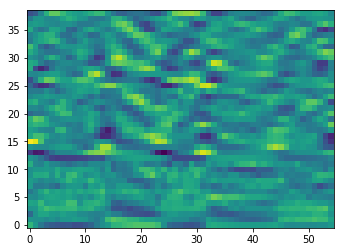

In [7]:
plt.imshow(train_x[3277].T, origin="bottom");

In [8]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [9]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

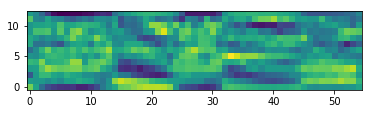

In [10]:
plt.imshow(train_x[3277].T, origin="bottom");

## Multi-layer sequence-to-sequence model with latent VAE representation

In [33]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 100  # 100
n_val_interval = 1
batch_size = 500
n_buckets = 3
keep_prob = 1.0

# Model parameters
n_input = d_frame
enc_n_hiddens = [400, 400, 400] # 150
dec_n_hiddens = [400, 400, 400]
build_latent_func = tflego.build_vae
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [dec_n_hiddens[0]],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_vae.tmp.ckpt")
model_fn = path.join(output_dir, "multi_lazydynamic_latent_vae.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_multi_encdec_lazydynamic_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type, keep_prob=keep_prob
    )
encoder_states = network_dict["encoder_states"]
vae = network_dict["latent_layer"]
z_mean = vae["z_mean"]
z_log_sigma_sq = vae["z_log_sigma_sq"]
z = vae["z"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# VAE loss
sigma_sq = 0.00001  # smaller values: care more about reconstruction
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = tflego.vae_loss_gaussian(x, y, sigma_sq, z_mean, z_log_sigma_sq, reconstruction_loss=reconstruction_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [34]:
def samediff_val():
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = SimpleIterator(
        val_x, len(val_x), False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, intermediate_model_fn)
        for batch_x_padded, batch_x_lengths in val_batch_iterator:
            np_x = batch_x_padded
            np_x_lengths = batch_x_lengths
            np_z = session.run(
                [z_mean], feed_dict={x: np_x, x_lengths: np_x_lengths}
                )[0]
#             np_y = session.run(
#                 [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
#                 )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

#     np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
#     distances = pdist(np_z_normalised, metric="cosine")
#     matches = samediff.generate_matches_array(labels)
#     ap, prb = samediff.average_precision(
#         distances[matches == True], distances[matches == False]
#         )
        
    # Same-different
    distances = pdist(np_z, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )    
    return [prb, -ap]

In [35]:
np.random.seed(1)
train_batch_iterator = SimpleBucketIterator(
    train_x, batch_size, n_buckets, True
    )
val_batch_iterator = SimpleBucketIterator(
    val_x, batch_size, n_buckets, False
    )

# record_dict = training.train_fixed_epochs(
#     n_epochs, optimizer, loss, train_batch_iterator,
#     [x, x_lengths], [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_fn
#     )
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, x_lengths], samediff_val, save_model_fn=intermediate_model_fn, save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval
    )

2018-08-25 11:27:59.895290
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
11.932 sec, train loss: 47741.4, val loss: [0.031172240051162082, -0.0084484332397204345] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
11.622 sec, train loss: 36306.5, val loss: [0.041741819118783816, -0.013119280490110101] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
11.644 sec, train loss: 34365.6, val loss: [0.057396871905687118, -0.018528607120733526] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
11.856 sec, train loss: 33245.1, val loss: [0.084459929426426938, -0.030096401144459335] *
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
12.680 sec, train loss: 31848.8, val loss: [0.095624164483510438, -0.0394

Epoch 42:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
13.025 sec, train loss: 15762.0, val loss: [0.28832775057974747, -0.235914723073641] *
Epoch 43:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
13.172 sec, train loss: 14693.0, val loss: [0.28832775057974747, -0.23161638559762945]
Epoch 44:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
13.355 sec, train loss: 15521.5, val loss: [0.29193506828137078, -0.23500323212472335]
Epoch 45:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
13.465 sec, train loss: 15219.0, val loss: [0.29116207163102292, -0.23435179100615927]
Epoch 46:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
14.702 sec, train loss: 14935.4, val loss: [0.28860269776627057, -0.23244154140224063]
Epoch 47:
INFO:tensorflow

Epoch 84:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
15.061 sec, train loss: 11874.7, val loss: [0.30249935583612469, -0.24960323060688444]
Epoch 85:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
14.933 sec, train loss: 11775.0, val loss: [0.3046110122792266, -0.25058200924116752]
Epoch 86:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
15.136 sec, train loss: 11808.1, val loss: [0.30199613183241603, -0.2477593704856649]
Epoch 87:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
16.428 sec, train loss: 11595.1, val loss: [0.30121102808554495, -0.24614845184293058]
Epoch 88:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.tmp.ckpt
15.198 sec, train loss: 11400.3, val loss: [0.30327235248647255, -0.24953282662527843]
Epoch 89:
INFO:tensorflow:R

In [36]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_mean], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_vae.ckpt


In [37]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.2561
Precision-recall breakeven: 0.3064


In [38]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.2592
Precision-recall breakeven: 0.3058


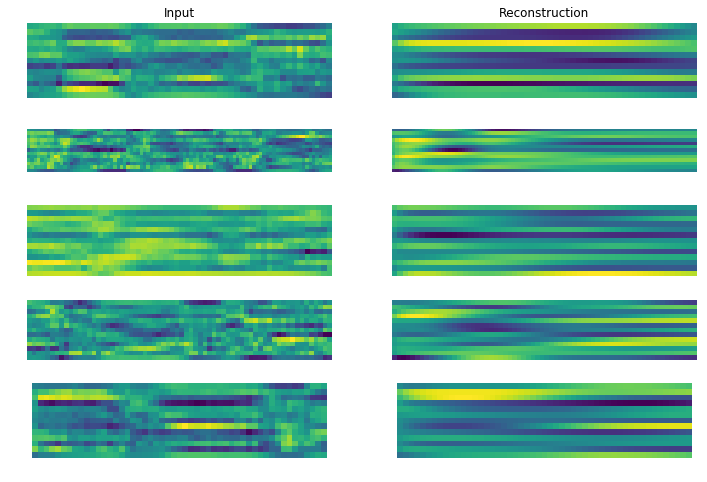

In [79]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

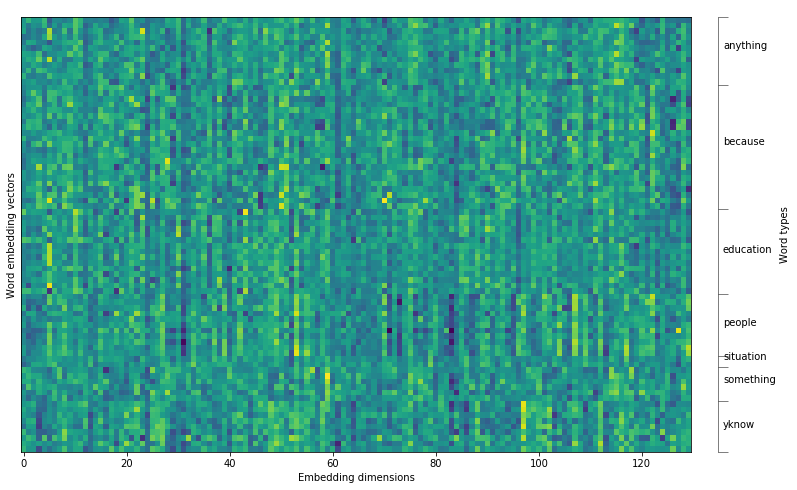

In [80]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )